In [1]:
# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

### Data

In [4]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [5]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [6]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [7]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [8]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [9]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [10]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [11]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [12]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [13]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [14]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [15]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [16]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


- Defining the Architecture of LSTM

# (1) Model having 1 LSTM layer with 32 LSTM Units

In [17]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history = model.fit(X_train, Y_train, batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 40s 5ms/step - loss: 1.3139 - acc: 0.4358 - val_loss: 1.1352 - val_acc: 0.4700
Epoch 2/30
7352/7352 [==============================] - 38s 5ms/step - loss: 0.9788 - acc: 0.5773 - val_loss: 0.9513 - val_acc: 0.5884
Epoch 3/30
7352/7352 [==============================] - 39s 5ms/step - loss: 0.7977 - 

Test Score: 0.488270
Test Accuracy: 88.293180%


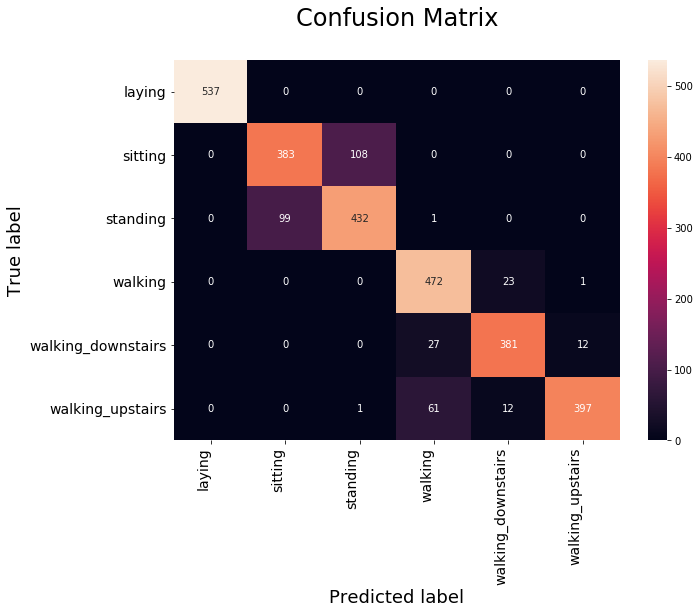

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores[0]))
print("Test Accuracy: %f%%" % (scores[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

- With a simple 2 layer architecture we got 88.29% accuracy and a loss of 0.488
- We can further imporve the performace with Hyperparameter tuning

# (2) Model having 1 LSTM layer with 48 LSTM Units and 'adam' as an optimizer

In [19]:
# Initiliazing the sequential model
model1 = Sequential()
# Configuring the parameters
model1.add(LSTM(48, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model1.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model1.add(Dense(n_classes, activation='sigmoid'))
print(model1.summary())

# Compiling the model
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Training the model
history1 = model1.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 48)                11136     
_________________________________________________________________
dropout_2 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 294       
Total params: 11,430
Trainable params: 11,430
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 45s 6ms/step - loss: 1.4210 - acc: 0.3677 - val_loss: 1.4543 - val_acc: 0.3424
Epoch 2/30
7352/7352 [==============================] - 43s 6ms/step - loss: 1.3615 - acc: 0.3659 - val_loss: 1.3897 - val_acc: 0.3502
Epoch 3/30
7352/7352 [==============================] - 43s 6ms/step - loss: 1.

Test Score: 0.344224
Test Accuracy: 87.139464%


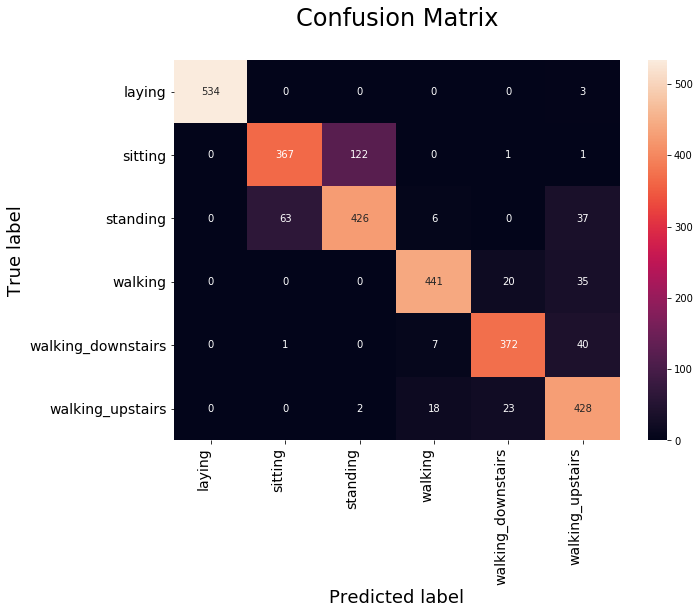

In [20]:
# Final evaluation of the model
scores1 = model1.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores1[0]))
print("Test Accuracy: %f%%" % (scores1[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model1.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# (3) Model having 1 LSTM layer with 48 LSTM Units and 'rmsprop' as an optimizer

In [21]:
# Initiliazing the sequential model
model2 = Sequential()
# Configuring the parameters
model2.add(LSTM(48, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model2.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model2.add(Dense(n_classes, activation='sigmoid'))
print(model2.summary())

# Compiling the model
model2.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history2 = model2.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 48)                11136     
_________________________________________________________________
dropout_3 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 294       
Total params: 11,430
Trainable params: 11,430
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 43s 6ms/step - loss: 1.2313 - acc: 0.4780 - val_loss: 1.0087 - val_acc: 0.5674
Epoch 2/30
7352/7352 [==============================] - 43s 6ms/step - loss: 0.8782 - acc: 0.6073 - val_loss: 0.8074 - val_acc: 0.6498
Epoch 3/30
7352/7352 [==============================] - 42s 6ms/step - loss: 0.

Test Score: 0.410484
Test Accuracy: 90.498812%


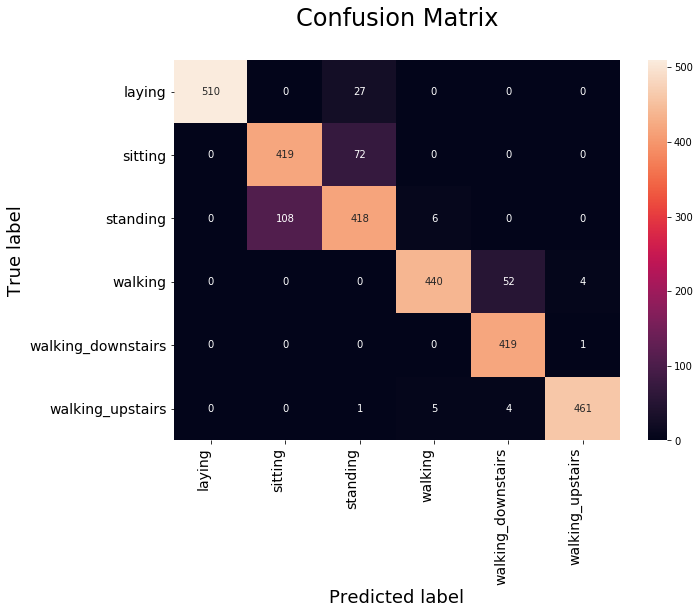

In [22]:
# Final evaluation of the model
scores2 = model2.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores2[0]))
print("Test Accuracy: %f%%" % (scores2[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model2.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# (4) Model having 1 LSTM layer with 64 LSTM Units and 'rmsprop' as an optimizer

In [23]:
# Initiliazing the sequential model
model3 = Sequential()
# Configuring the parameters
model3.add(LSTM(64, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model3.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model3.add(Dense(n_classes, activation='sigmoid'))
print(model3.summary())

# Compiling the model
model3.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history3 = model3.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 47s 6ms/step - loss: 1.2746 - acc: 0.4457 - val_loss: 1.1393 - val_acc: 0.5246
Epoch 2/30
7352/7352 [==============================] - 46s 6ms/step - loss: 0.9587 - acc: 0.6020 - val_loss: 0.8720 - val_acc: 0.6349
Epoch 3/30
7352/7352 [==============================] - 46s 6ms/step - loss: 1.

Test Score: 0.299268
Test Accuracy: 92.059722%


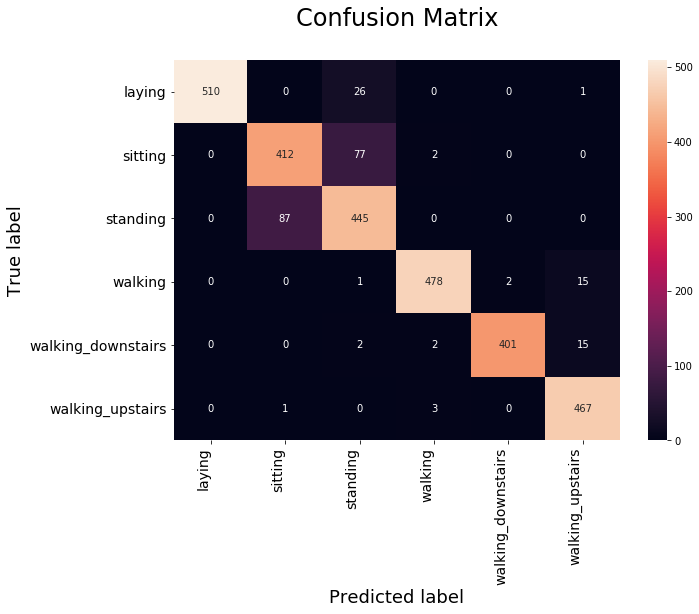

In [24]:
# Final evaluation of the model
scores3 = model3.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores3[0]))
print("Test Accuracy: %f%%" % (scores3[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model3.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# (5) Model having 2 LSTM layer with 32 LSTM Units and 'rmsprop' as an optimizer

In [25]:
# Initiliazing the sequential model
model4 = Sequential()
# Configuring the parameters
model4.add(LSTM(32,return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model4.add(Dropout(0.5))

# Configuring the parameters
model4.add(LSTM(32))
# Adding a dropout layer
model4.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model4.add(Dense(n_classes, activation='sigmoid'))
print(model4.summary())

# Compiling the model
model4.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history4 = model4.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 198       
Total params: 13,894
Trainable params: 13,894
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 86s 12ms/step - loss: 1.2107 

Test Score: 0.545492
Test Accuracy: 89.921955%


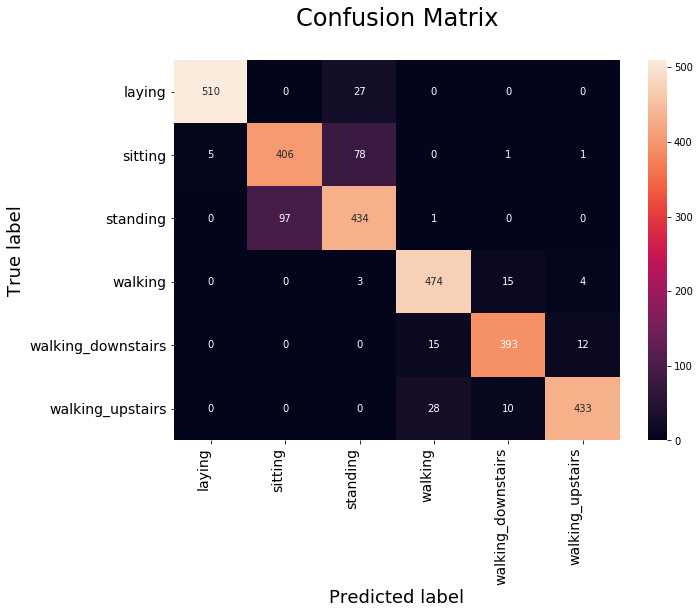

In [26]:
# Final evaluation of the model
scores4 = model4.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores4[0]))
print("Test Accuracy: %f%%" % (scores4[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model4.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# (6) Model having 2 LSTM layer with 64 LSTM Units and 'rmsprop' as an optimizer

In [27]:
# Initiliazing the sequential model
model5 = Sequential()
# Configuring the parameters
model5.add(LSTM(64,return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model5.add(Dropout(0.7))

# Configuring the parameters
model5.add(LSTM(64))
# Adding a dropout layer
model5.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model5.add(Dense(n_classes, activation='sigmoid'))
print(model5.summary())

# Compiling the model
model5.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history5 = model5.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 128, 64)           18944     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 390       
Total params: 52,358
Trainable params: 52,358
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 110s 15ms/step - loss: 1.1611

Test Score: 0.412691
Test Accuracy: 90.939939%


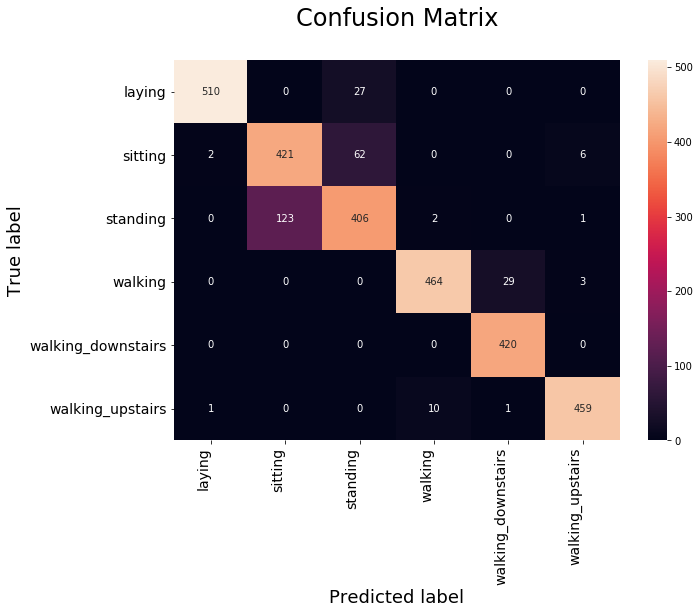

In [28]:
# Final evaluation of the model
scores5 = model5.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores5[0]))
print("Test Accuracy: %f%%" % (scores5[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model5.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# CONCLUSION

# (a). Procedure Followed :

STEP 1 :- Load the data and split into training_data and test_data 

STEP 2:-Try out different LSTM architectures

STEP 3:- Find test score and accuracy for each model 

STEP 4:- Draw confusion matrix using seaborn heatmap for each model

# (b). Table (Model performances) :

In [29]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

# Names of models
names =['1 LSTM layer with 32 LSTM Units(Optimizer-->rmsprop)','1 LSTM layer with 48 LSTM Units(Optimizer-->adam)',\
        '1 LSTM layer with 48 LSTM Units(Optimizer-->rmsprop)','1 LSTM layer with 64 LSTM Units(Optimizer-->rmsprop)',\
        '2 LSTM layer with 32 LSTM Units(Optimizer-->rmsprop)','2 LSTM layer with 64 LSTM Units(Optimizer-->rmsprop)']

# Training accuracies
train_acc = [history.history['acc'][29],history1.history['acc'][29],history2.history['acc'][29],\
             history3.history['acc'][29],history4.history['acc'][29],history5.history['acc'][29]]

# Test accuracies
test_acc =[scores[1],scores1[1],scores2[1],scores3[1],scores4[1],scores5[1]]

numbering = [1,2,3,4,5,6]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Training Accuracy",train_acc)
ptable.add_column("Test Accuracy",test_acc)

# Printing the Table
print(ptable)

+-------+------------------------------------------------------+--------------------+--------------------+
| S.NO. |                        MODEL                         | Training Accuracy  |   Test Accuracy    |
+-------+------------------------------------------------------+--------------------+--------------------+
|   1   | 1 LSTM layer with 32 LSTM Units(Optimizer-->rmsprop) | 0.9411044613710555 | 0.8829317950458093 |
|   2   |  1 LSTM layer with 48 LSTM Units(Optimizer-->adam)   | 0.9272306855277476 | 0.8713946386155412 |
|   3   | 1 LSTM layer with 48 LSTM Units(Optimizer-->rmsprop) | 0.9470892274211099 | 0.9049881235154394 |
|   4   | 1 LSTM layer with 64 LSTM Units(Optimizer-->rmsprop) | 0.948993471164309  | 0.9205972175093315 |
|   5   | 2 LSTM layer with 32 LSTM Units(Optimizer-->rmsprop) | 0.9532100108813928 | 0.8992195453003053 |
|   6   | 2 LSTM layer with 64 LSTM Units(Optimizer-->rmsprop) | 0.9485854189336235 | 0.9093993892093655 |
+-------+----------------------------